In [91]:
# Import packages:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
#sns.set() # ?



import os
import cv2

# sklearn imports
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, recall_score, precision_recall_curve,f1_score, fbeta_score, confusion_matrix # the metrics we'll be looking at.


# keras imports
from tensorflow import keras
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import model_to_dot
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.layers import Input, Embedding, Bidirectional, LSTM

from tensorflow.keras.applications import mobilenet_v2
from tensorflow.keras.preprocessing import image
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint



# Load data:

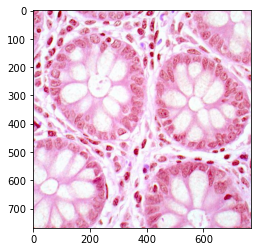

In [3]:
DATA_DIR = '/Users/ignasisols/Metis_projects/metis_DeepLearning_project/lung_colon_image_set/colon_image_sets/'
CATEGORIES = ['benign','adenocarcinoma']

# First, check one of the images:
for category in CATEGORIES:
    path = os.path.join(DATA_DIR,category) # path to adenocarcinome and benign folders.
    for img in os.listdir(path):
        img_array = cv2.imread(os.path.join(path,img)) # cv2.IMREAD_GRAYSCALE
        plt.imshow(img_array)
        plt.show()
        break
    break
                               
                               

In [4]:
# Print the categories and their assigned number (0,1) as a sanity check:
for category in CATEGORIES:
    print(CATEGORIES.index(category),category)

0 benign
1 adenocarcinoma


In [5]:
# Load all the images:

IMG_SIZE = 128
all_images = []

def create_array_all_image():
    for category in CATEGORIES:
        path = os.path.join(DATA_DIR,category) # path to adenocarcinome and benign folders.
        class_num = CATEGORIES.index(category)
        for img in os.listdir(path):
            img_array = cv2.imread(os.path.join(path,img)) # cv2.IMREAD_GRAYSCALE
            new_array = cv2.resize(img_array,(IMG_SIZE,IMG_SIZE))
            all_images.append([new_array, class_num])
            
create_array_all_image()

# Train-test split

In [10]:
X = []
y = []

In [11]:
for features, label in all_images: 
    X.append(features)
    y.append(label)

In [12]:
X = np.array(X).reshape(-1,IMG_SIZE,IMG_SIZE,3) # Resize
y = np.array(y)

In [14]:
# Save pickled X and y:

pickle_out = open('X.pickle','wb')
pickle.dump(X,pickle_out)
pickle_out.close()

pickle_out = open('y.pickle','wb')
pickle.dump(y,pickle_out)
pickle_out.close()

In [ ]:
# load pickled X and Y:

pickle_in = open('X.pickle','rb')
X = pickle.load(pickle_in)

pickle_in_y = open('y.pickle','rb')
y = pickle.load(pickle_in_y)

In [15]:
# Train/test split:

X_train, X_test, y_train, y_test = (train_test_split(X, y, 
                                                     test_size = .2, random_state = 42))




# Standarization

In [16]:
scaler = StandardScaler()
# This standarization takes place at each channel independently
X_train = scaler.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape) # Flattens X_train, for each channel independently. Fit_transform and reshapes X_train back to original shape.
X_test = scaler.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape) # Same as above but we only transform!

# Baseline

In [17]:
# Reshape X_train and X_test to be able to perform PCA:
X_train_for_baselines = X_train.reshape(X_train.shape[0],-1)
X_test_for_baselines = X_test.reshape(X_test.shape[0],-1)

<AxesSubplot:>

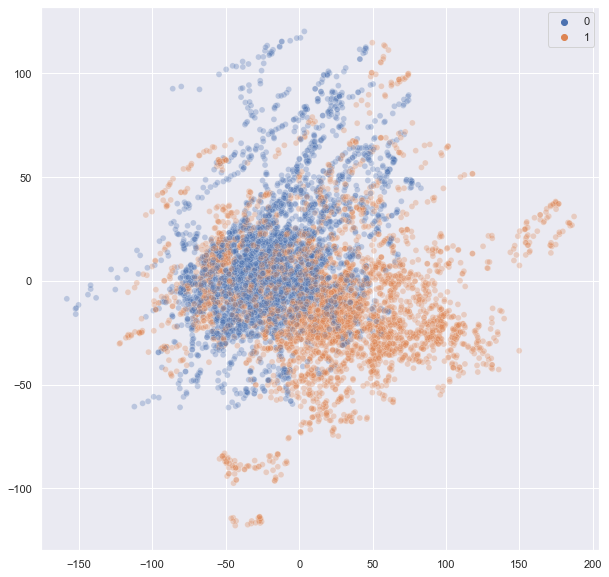

In [18]:
# PCA:
pca = PCA(n_components=2)

X_train_2PC = pca.fit_transform(X_train_for_baselines)
X_test_2PC = pca.transform(X_test_for_baselines)

sns.set(rc={'figure.figsize':(10,10)})

sns.scatterplot(x=X_train_2PC[:, 0], y=X_train_2PC[:, 1],
                hue=y_train, alpha=.3)

### Linear Regression:

In [48]:
lr = LogisticRegression()
lr.fit(X_train_2PC, y_train)
print('Acuracy:',lr.score(X_test_2PC, y_test))

Acuracy: 0.7355


In [49]:
print('Recall:',recall_score(y_test, lr.predict(X_test_2PC), average=None)[1])

Recall: 0.6928645294725957


In [204]:
print('Precision:', precision_score(y_test, lr.predict(X_test_2PC), average=None)[1])

Precision: 0.7427937915742794


In [77]:
def confusion_matrix_(model,y_test,X_test):
    logit_confusion = confusion_matrix(y_test, model.predict(X_test))
    sns.heatmap(logit_confusion,cmap=plt.cm.Blues, annot=True, fmt='g',square=True,xticklabels=CATEGORIES, yticklabels=CATEGORIES) #  xticklabels=CATEGORIES, yticklabels=CATEGORIES

    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Logistic regression confusion matrix');

    plt.savefig("confusion_matrix_logit_iris")

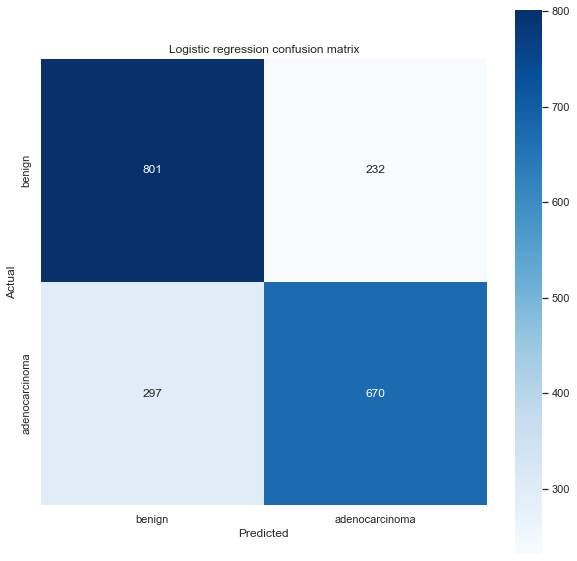

In [78]:
confusion_matrix_(lr,y_test,X_test_2PC)

## Random forests:

In [50]:
###  Random forests classifier:
randomforest = RandomForestClassifier(n_estimators=100)
randomforest.fit(X_train_2PC, y_train)
randomforest.score(X_test_2PC, y_test)

0.804

In [51]:
# Fbeta score:
fbeta_score(y_test, randomforest.predict(X_test_2PC), beta=2)

0.7816739720308912

In [52]:
recall_score(y_test, randomforest.predict(X_test_2PC), average=None)[1]

0.7745604963805585

In [205]:
print('Precision:', precision_score(y_test, randomforest.predict(X_test_2PC), average=None)[1])

Precision: 0.8114842903575298


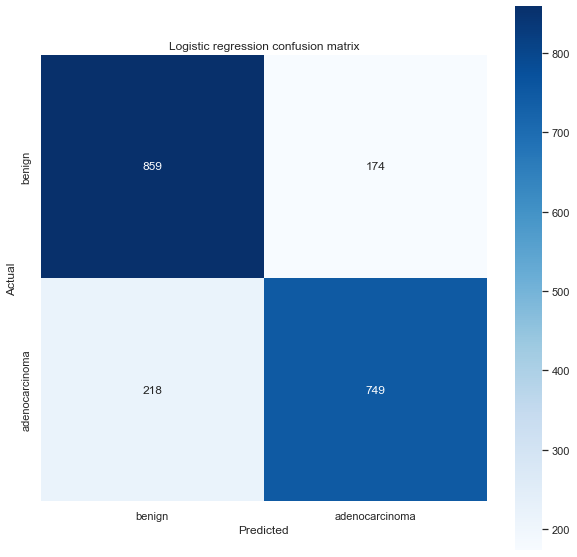

In [79]:
confusion_matrix_(randomforest,y_test,X_test_2PC)

# Convolutional neural network (without transfer Learning):

In [97]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, GlobalAveragePooling2D, InputLayer
'''
 In this network structure, note that we follow the typical CNN heuristic of 
 gradually reducing width and height dimenions over time with max pooling
 (typically by a factor of 2), but increasing the filter depth dimension 
 to find increasingly specific patterns. These models are typically compromised 
 of a series of convolutional blocks followed by a flattening operation and 
 a series of fully connected layers at the terminus.
'''

NN = Sequential()

NN.add(InputLayer(input_shape=X_train.shape[1:]))

# Conv block 1.  You can add more conv steps to
# each block to increase model capacity.
NN.add(Conv2D(filters=20, kernel_size=3, activation='relu', padding='same'))
# NN.add(Conv2D(filters=16, kernel_size=3, activation='relu', padding='same'))
NN.add(MaxPooling2D())

# Conv block 2 - note we increase filter dimension as we move
# further into the network. You can add more conv steps to
# each block to increase model capacity.
NN.add(Conv2D(filters=20, kernel_size=3, activation='relu', padding='same'))
# NN.add(Conv2D(filters=16, kernel_size=3, activation='relu', padding='same'))
NN.add(MaxPooling2D())

# Fully connected block - flattening followed by dense and output layers
NN.add(Flatten())

NN.add(Dense(20, activation='relu'))
NN.add(Dense(1, activation='sigmoid'))  # 10 target classes

In [98]:
NN.compile(
    loss='BinaryCrossentropy',
    optimizer='adam',
    metrics=['accuracy','Recall','Precision'],
)
NN.summary()

history = NN.fit(X_train, y_train, epochs=20, verbose=1, validation_split=0.20,
       callbacks=[
           ModelCheckpoint(
               'models/mnist.{epoch:02d}-{val_loss:.2f}.hdf5',
               save_best_only=True),
           EarlyStopping(monitor='val_loss', patience=3)
       ])  # track progress as we fit

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 128, 128, 20)      560       
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 64, 64, 20)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 64, 64, 20)        3620      
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 32, 32, 20)        0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 20480)             0         
_________________________________________________________________
dense_10 (Dense)             (None, 20)                409620    
_________________________________________________________________
dense_11 (Dense)             (None, 1)                

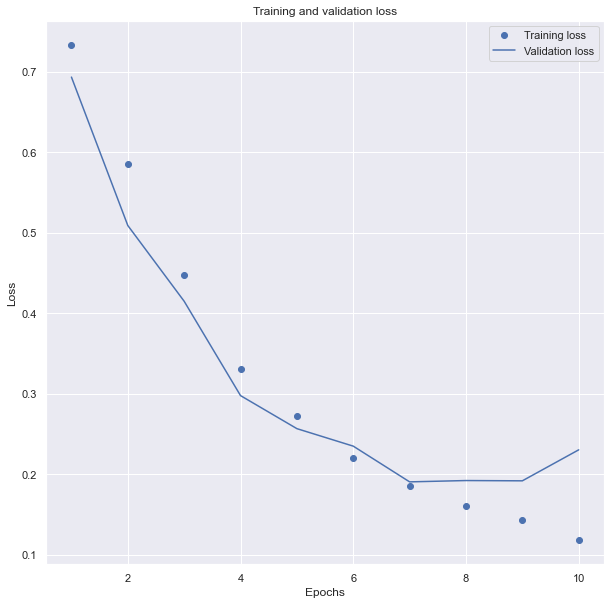

In [99]:
import matplotlib.pyplot as plt 
history_dict = history.history

loss_values = history_dict["loss"]

val_loss_values = history_dict["val_loss"]
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, "bo", label="Training loss")
plt.plot(epochs, val_loss_values, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [100]:
results = NN.evaluate(X_test, y_test)
results

63/63 [==============================] - 3s 39ms/step - loss: 0.2826 - accuracy: 0.9230 - recall: 0.9886 - precision: 0.8699


[0.2825944125652313, 0.9229999780654907, 0.988624632358551, 0.8698816895484924]

/Users/ignasisols/opt/anaconda3/envs/metis/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


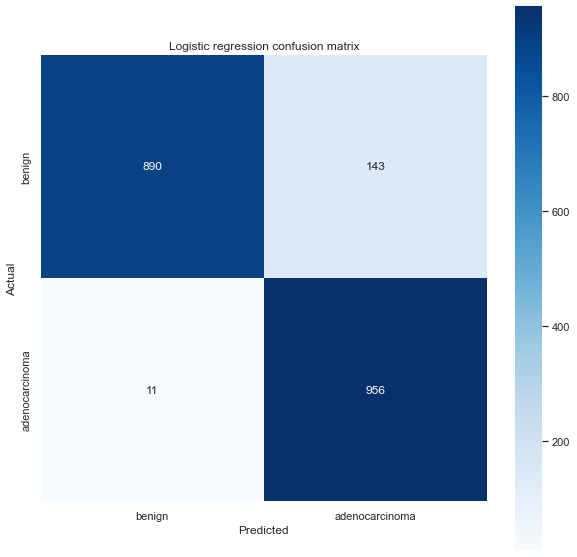

In [101]:
confusion_matrix_forKeras(NN,y_test,X_test)

# CNN with Transfer Learning:

In [165]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, GlobalAveragePooling2D, InputLayer
from tensorflow.keras.applications import mobilenet_v2


'''
 In this network structure, note that we follow the typical CNN heuristic of 
 gradually reducing width and height dimenions over time with max pooling
 (typically by a factor of 2), but increasing the filter depth dimension 
 to find increasingly specific patterns. These models are typically compromised 
 of a series of convolutional blocks followed by a flattening operation and 
 a series of fully connected layers at the terminus.
'''

# This is all we need to load and use the full pretrained model!
# note we exclude the final dense layers by setting include_top=False,
# and add new ones to train from scratch below
base_model = mobilenet_v2.MobileNetV2(weights='imagenet', include_top=False, input_shape=(128,128,3)) 


base_model.trainable = False
for layer in base_model.layers:
    layer.trainable = False
    


NN_mobileNet = Sequential()

NN_mobileNet.add(InputLayer(input_shape=X_train.shape[1:]))


NN_mobileNet.add(base_model)



# Conv block 1.  You can add more conv steps to
# each block to increase model capacity.
NN_mobileNet.add(Conv2D(filters=20, kernel_size=3, activation='relu', padding='same'))
# NN.add(Conv2D(filters=16, kernel_size=3, activation='relu', padding='same'))
NN_mobileNet.add(MaxPooling2D())

# Conv block 2 - note we increase filter dimension as we move
# further into the network. You can add more conv steps to
# each block to increase model capacity.
NN_mobileNet.add(Conv2D(filters=20, kernel_size=3, activation='relu', padding='same'))
# NN.add(Conv2D(filters=16, kernel_size=3, activation='relu', padding='same'))
NN_mobileNet.add(MaxPooling2D())

# Fully connected block - flattening followed by dense and output layers
NN_mobileNet.add(Flatten())

NN_mobileNet.add(Dense(20, activation='relu'))
NN_mobileNet.add(Dense(1, activation='sigmoid'))  # 10 target classes

In [131]:
del NN_mobileNet

In [166]:
NN_mobileNet.compile(
    loss='BinaryCrossentropy',
    optimizer='adam',
    metrics=['accuracy','Recall','Precision'],
)
NN_mobileNet.summary()

history = NN_mobileNet.fit(X_train, y_train, epochs=20, verbose=1, validation_split=0.20,
       callbacks=[
           ModelCheckpoint(
               'models/mnist.{epoch:02d}-{val_loss:.2f}.hdf5',
               save_best_only=True),
           EarlyStopping(monitor='val_loss', patience=3)
       ])  # track progress as we fit

Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_128 (Functi (None, 4, 4, 1280)        2257984   
_________________________________________________________________
conv2d_34 (Conv2D)           (None, 4, 4, 20)          230420    
_________________________________________________________________
max_pooling2d_34 (MaxPooling (None, 2, 2, 20)          0         
_________________________________________________________________
conv2d_35 (Conv2D)           (None, 2, 2, 20)          3620      
_________________________________________________________________
max_pooling2d_35 (MaxPooling (None, 1, 1, 20)          0         
_________________________________________________________________
flatten_17 (Flatten)         (None, 20)                0         
_________________________________________________________________
dense_34 (Dense)             (None, 20)              

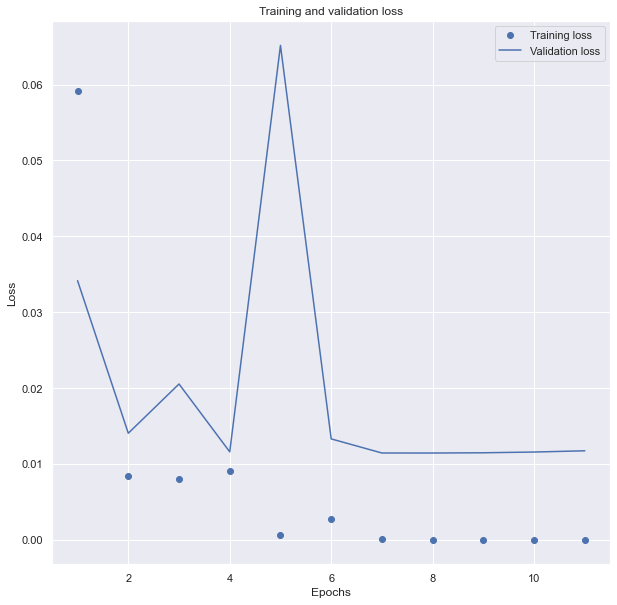

In [167]:
import matplotlib.pyplot as plt 
history_dict = history.history

loss_values = history_dict["loss"]

val_loss_values = history_dict["val_loss"]
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, "bo", label="Training loss")
plt.plot(epochs, val_loss_values, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [164]:
del NN_mobileNet

In [169]:
results_mobileNetV2 = NN_mobileNet.evaluate(X_test, y_test)
results_mobileNetV2

63/63 [==============================] - 10s 133ms/step - loss: 0.0123 - accuracy: 0.9970 - recall: 0.9969 - precision: 0.9969


[0.012255067005753517,
 0.996999979019165,
 0.9968976378440857,
 0.9968976378440857]

/Users/ignasisols/opt/anaconda3/envs/metis/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


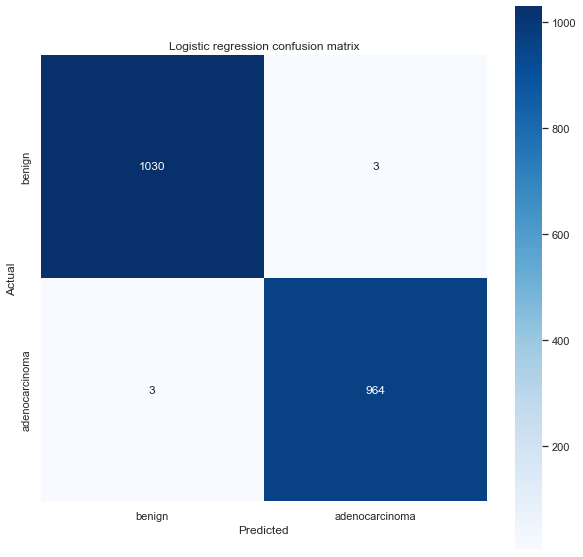

In [168]:
confusion_matrix_forKeras(NN_mobileNet,y_test,X_test)

In [170]:
X_test.shape

(2000, 128, 128, 3)

In [171]:
predicted = NN_mobileNet.predict_classes(X_test)   


/Users/ignasisols/opt/anaconda3/envs/metis/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [172]:
cancer_FN = []
benign_FN = []
for i in range(len(predicted)):
    if y_test[i] == 1 and predicted[i] == 0:
        cancer_FN.append(i)
    elif y_test[i] == 0 and predicted[i] == 1:
        benign_FN.append(i)

In [173]:
benign_FN

[1004, 1283, 1650]

In [174]:
cancer_FN

[662, 1125, 1603]

In [ ]:
# For plotting the original images (before they were scaled and standarized):

X_train_forPlot, X_test_forPlot, y_train_forPlot, y_test_forPlot = (train_test_split(X, y, 
                                                     test_size = .2, random_state = 42))


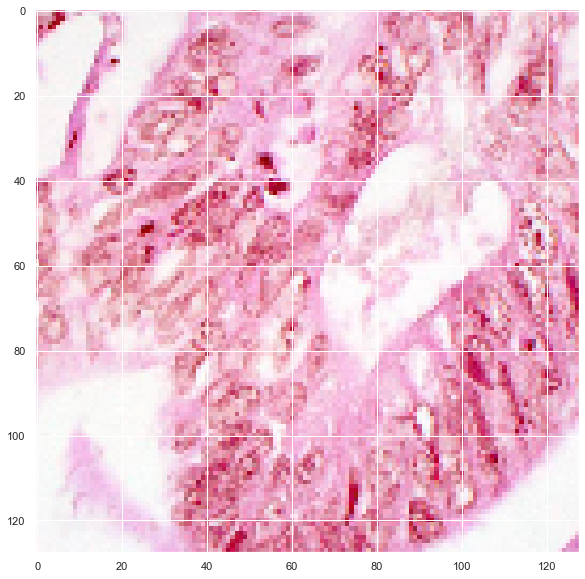

In [203]:
plt.imshow(X_test_forPlot[1125])